# Wavelets 


**Content Creator**: Maria de Fátima Dias

Wavelets is a mathematical procedure used to divide the signal into different scale components. Below you can find an example to divide the EEG signal into segments of a given length and an example of how to decompose a segment into scaling components using wavelet decomposition. Moreover, you can play with a widget and analyse the impact of different mother wavelets in the decomposition.


In [11]:
#@title
# Imports and data dowbload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request 
import math
import pywt
from typing import List

url_data = 'https://github.com/mfmachado/adar/raw/main/resources/data_example.csv'
data_filename = 'data_example'
_=urllib.request.urlretrieve(url_data, data_filename)

In [12]:
def windowing_signal(df_signal: pd.DataFrame, fs: int, window_sec_length: float, overlapping: float=None) -> List[pd.DataFrame]:
  """
  This function applies a sliding window to the signal and divides the signal 
  into multiple portions of signal with window_sec_length seconds (the window 
  length). If the overlapping is None then the sliding window is non-overlap 
  otherwise the step of the sliding window is given by the overlapping variable.
  """
  if overlapping is None:
    step = math.ceil(fs*window_sec_length)
  else:
    step= math.ceil(fs*overlapping)

  segments = []
  for i in range(0, df_signal.shape[0]-step+1, step):
      segments.append(df_signal.iloc[i:i+step])
  return segments

## Segment the signal

In [13]:
df_all = pd.read_csv(url_data)
freq_sample =  1/(df_all.iloc[1].times - df_all.iloc[0].times)
segments = windowing_signal(df_all, freq_sample, 30)

#### Plot some segments

Plot the first segments of the data

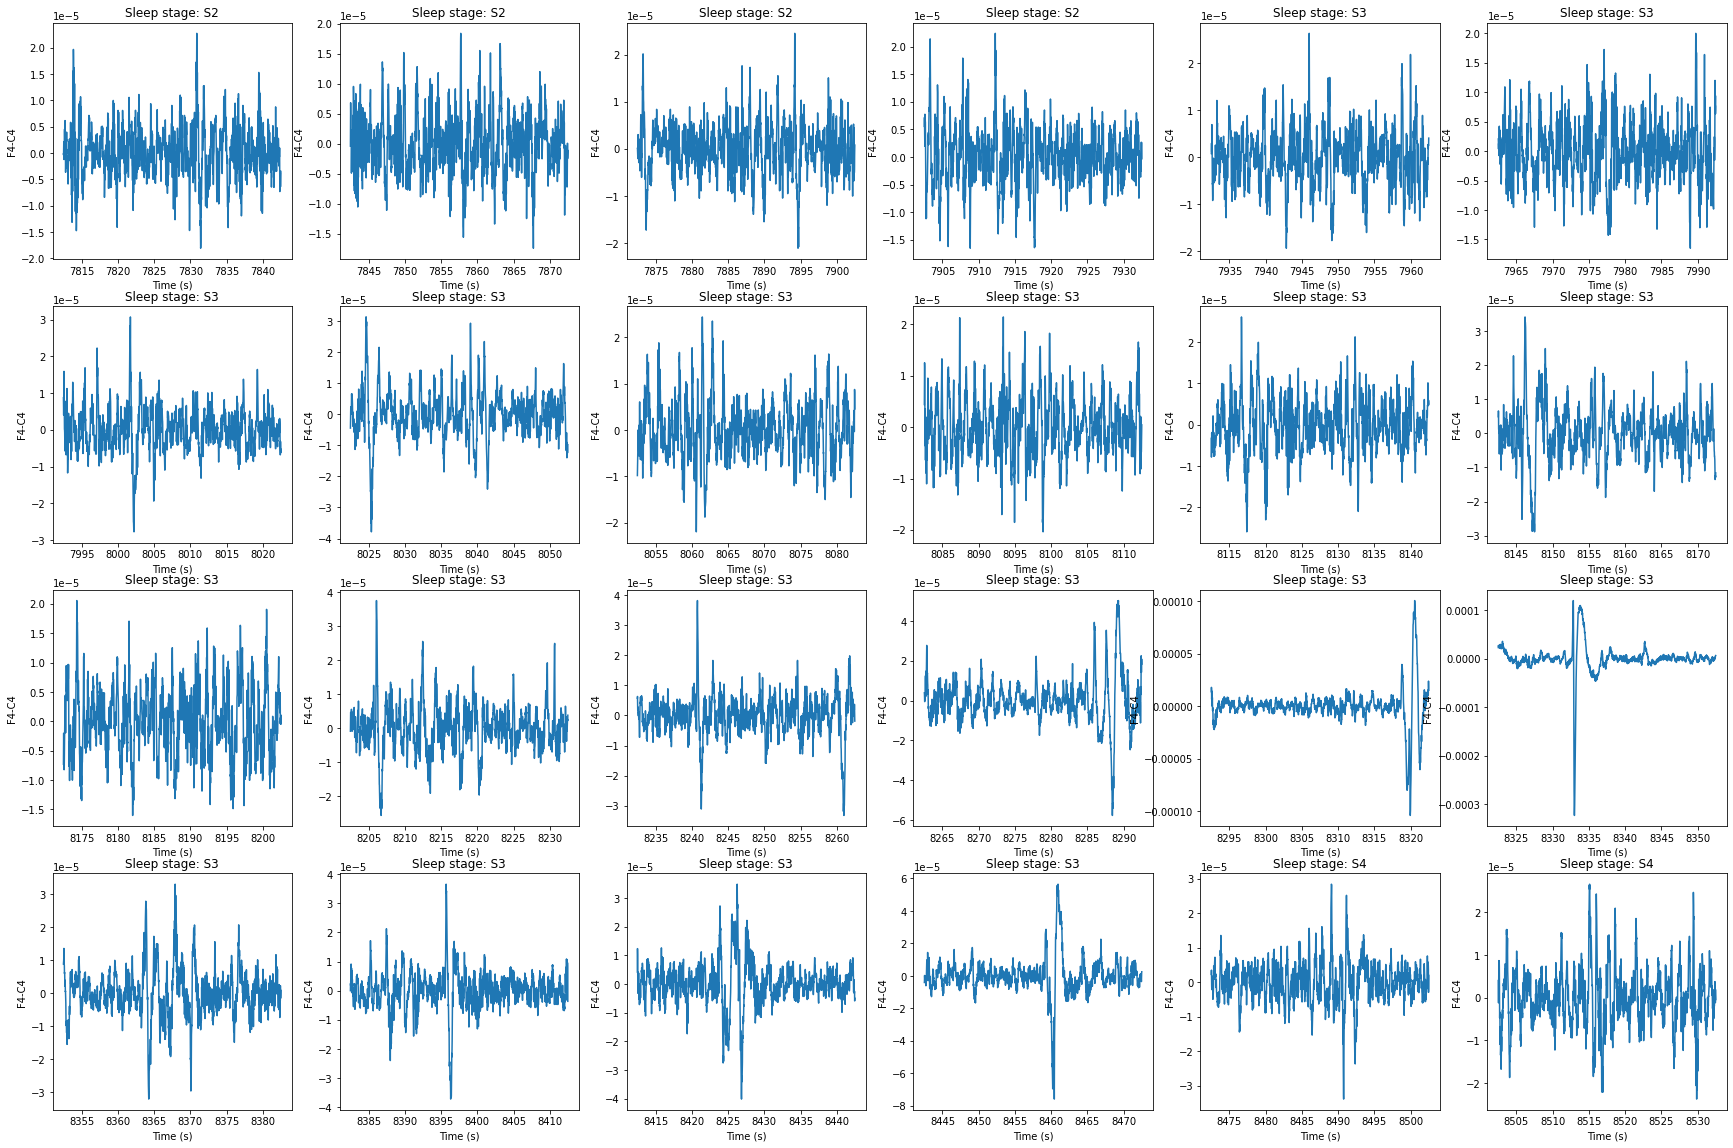

In [14]:
channel = "F4-C4"
n_rows = 4
n_columns = 6
f = plt.figure(figsize=(n_columns*5, n_rows*5))
for i in range(n_rows*n_columns):
  f.add_subplot(n_rows, n_columns, i + 1)
  plt.plot(segments[i]["times"], segments[i][channel])
  plt.xlabel("Time (s)")
  plt.ylabel(channel)
  plt.title(f'Sleep stage: {np.unique(segments[i]["sleepstage"])[0]}')

### Apply Wavelets to the signal

PyWavelets implements multiple wavelets families, you can check the available families with:

```
import pywt
families = pywt.families()
print(f'Available families: {families}')
```

The wavelet names for the given family name can be obtained using the code:
```
family_choosen = families[1]
wavelet_names = pywt.wavelist(family_choosen) 
print(f'Available wavleets names: {wavelet_names} for the family: {family_choosen}.')
```

Below you can play with the widget to verify the impact of the mother wavelet in the decomposition.

In [16]:
#@title
from ipywidgets import *

# Some function you want executed
def wavelet_decomp(family, mother_wavelet, levels):
  if len(mother_wavelet) > 1:

    
    result = pywt.Wavelet(mother_wavelet).wavefun(level=levels)
    if len(result) == 3:
      phi, psi, x = result
    else:
      phi_d, psi, phi_r, psi_r, x = result 
      
    single_segment = segments[0][channel]
    fig, ax = plt.subplots(levels+3, 1, figsize=(25, 4*(levels+3)))
    
    ax[0].plot(x, psi)
    ax[0].set_title("Mother wavelet")

    ax[1].plot(single_segment)
    ax[1].set_title("Original Signal")

    wavelets = pywt.wavedec(single_segment, mother_wavelet, level=levels)

    for i in range(1, len(wavelets)):
        ax[i+1].plot(wavelets[-i])
        ax[i+1].set_title(f'Decomposition Level: {i} Mother Wavelet:{mother_wavelet}')
    ax[-1].set_title(f'Remaining coef: {i} Mother Wavelet:{mother_wavelet}')
    ax[-1].plot(wavelets[0])

family_widget = Dropdown(options = pywt.families())
wavelet_widget = Dropdown()

# Define a function that updates the content of y based on what we select for x
def update(*args):
    options = ['']
    options.extend(pywt.wavelist(family_widget.value, kind='discrete'))
    wavelet_widget.options = options

family_widget.observe(update)


interact(wavelet_decomp, family = family_widget,
         mother_wavelet = wavelet_widget, levels=range(2, 10));


interactive(children=(Dropdown(description='family', options=('haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dm…